In [3]:
#importing libraries
import os
import re
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
#my queries in a list
QUERIES = [
    "How effective are inhalations of mucolytic agents in the treatment of CF patients",
    "What is the role of aerosols in the treatment of lung disease in CF patients",
    "What is the role of bacterial phagocytosis by alveolar macrophages or polymorphonuclear leukocytes in lung disease in CF patients",
    "What is the relationship between Haemophilus influenzae and Pseudomonas aeruginosa in CF patients",
    "Do CF patients ever develop infection in organs other than the lung If so in what organs",
    "What is the role of bacteria other than Pseudomonas aeruginosa Staphylococcus aureus or Haemophilus influenzae in the pathogenesis of lung disease in CF patients of lung disease in CF patients",
    "What is the role of fungi in the pathogenesis of lung disease in CF patients",
    "What is the role of viral infection in the lung disease of CF patients",
    "What is the epidemiology of Pseudomonas aeruginosa in CF patients",
    "What factors are responsible for the appearance of mucoid strains of Pseudomonas aeruginosa in CF patients",
    "What are the unusual manifestations of CF other than lung disease or exocrine pancreatic insufficiency",
    "What is the prognosis for survival of patients with CF",
    "Do CF patients have normal intelligence",
    "What animal models are available which are relevant to CF",
    "What abnormalities of skeletal muscle function or structure have been found in CF patients",
    "Is there an increased incidence of dental problems eg caries or periodontal disease in CF patients",
    "Is oxygen transport by red blood cells abnormal in CF patients",
    "What are the effects of CF on the development and or function of the brain and central nervous system",
    "Are there abnormalities of taste in CF patients",
    "What is the incidence of and treatment for hypertrophic osteoarthropathy in CF patients"
]

In [5]:
#relevant.txt file locating
base_dir = os.getcwd() 
docs_folder = os.path.join(base_dir, "docs")
relevant_file_path = os.path.join(base_dir, "Relevant.txt")

In [11]:
#stopwords for removing afterwards
stopwords = {
    "a", "an", "the", "this", "that", "these", "those", "such",
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves",
    "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself",
    "she", "her", "hers", "herself",
    "it", "its", "itself",
    "they", "them", "their", "theirs", "themselves",
    "one", "ones", "someone", "somebody", "everyone", "everybody", "noone", "nobody", "anyone", "anybody",
    "anything", "everything", "nothing", "something",
    "am", "is", "are", "was", "were", "be", "been", "being",
    "do", "does", "did", "doing", "have", "has", "had", "having",
    "can", "could", "may", "might", "shall", "should", "will", "would", "must", "ought",
    "not", "no", "nor", "neither", "none", "never", "without",
    "and", "or", "but", "if", "while", "although", "though", "because", "since", "so", "than",
    "as", "at", "by", "for", "from", "in", "into", "of", "off", "on", "out", "over", "through", "to", "toward",
    "under", "until", "up", "upon", "with", "within", "between", "before", "after", "during", "about", "around",
    "also", "very", "too", "just", "even", "still", "yet", "already", "here", "there", "when", "where",
    "how", "why", "once", "then", "ever", "always", "often", "sometimes", "rarely", "seldom",
    "all", "any", "both", "each", "either", "few", "many", "much", "more", "most", "some", "several",
    "various", "enough", "less", "least", "lot", "lots", "plenty",
    "now", "today", "tonight", "tomorrow", "yesterday", "ago", "soon", "later",
    "therefore", "thus", "however", "hence", "meanwhile",
    "okay", "ok", "yes", "no", "well", "oh", "hey", "hi", "hello", "thanks", "thank", "please",
    "like", "just", "really", "actually", "basically", "literally",
    "aren't", "isn't", "wasn't", "weren't", "hasn't", "haven't", "hadn't",
    "doesn't", "don't", "didn't", "won't", "wouldn't", "can't", "couldn't", "shouldn't", "mustn't",
    "i'm", "you're", "he's", "she's", "it's", "we're", "they're",
    "i've", "you've", "we've", "they've",
    "i'll", "you'll", "he'll", "she'll", "we'll", "they'll",
    "i'd", "you'd", "he'd", "she'd", "we'd", "they'd",
    "that's", "there's", "what's", "who's", "where's", "when's", "why's", "how's",
    "let's", "ain't", "y'all", "ya", "gonna", "wanna", "gotta",
    "own", "same", "else", "per", "via", "etc", "among", "beside", "despite",
    "towards", "regarding", "including", "excluding", "whether", "whichever", "whatever",
}

In [6]:
#function to remove stop words
def preprocess(word: str):
    w = re.sub(r"[^a-z]", "", word.lower())
    if len(w) > 1 and w not in stopwords:
        return w
    return None

In [13]:
#load doc words in a list
def load_and_preprocess_documents():
    documents = {}

    for doc_id in range(1, 1240):
        file_path = os.path.join(docs_folder, f"{doc_id:05d}")
        if os.path.exists(file_path):
            with open(file_path, "r", encoding="utf-8") as f:
                words = [line.strip().lower() for line in f if line.strip()]
        else:
            words = []

        cleaned_words = []
        for w in words:
            p = preprocess(w)
            if p:
                cleaned_words.append(p)
        documents[doc_id] = cleaned_words

    print("Διαβάστηκαν", len(documents), "έγγραφα.")

    doc_ids = []
    texts = []
    for doc_id in sorted(documents.keys()):
        tokens = documents[doc_id]
        text = " ".join(tokens)
        doc_ids.append(doc_id)
        texts.append(text)

    print("Δημιουργήθηκαν", len(doc_ids), "κείμενα για embeddings.")
    return doc_ids, texts

In [14]:
#function to load all relevant lists
def load_all_relevant_lists():
    all_rels = []
    if not os.path.exists(relevant_file_path):
        print("File not found:", relevant_file_path)
        return all_rels

    with open(relevant_file_path, "r", encoding="utf-8") as f:
        lines = [line.strip().lower() for line in f if line.strip()]

    for line in lines:
        words = line.split()
        nums = [int(x) for x in words]
        all_rels.append(nums)

    print("Loaded", len(all_rels), "relevance sets from Relevant.txt")
    return all_rels

In [15]:
#my metrics
def TP(list_a, list_b):
    set_a = set(list_a)
    set_b = set(list_b)
    return len(set_a.intersection(set_b))

def FP(list_a, list_b):
    set_a = set(list_a)
    set_b = set(list_b)
    return len(set_a.difference(set_b))

def FN(list_a, list_b):
    set_a = set(list_a)
    set_b = set(list_b)
    return len(set_b.difference(set_a))

def precision(a, b):
    tp = TP(a, b)
    fp = FP(a, b)
    return tp / (tp + fp) if (tp + fp) else 0.0

def recall(a, b):
    tp = TP(a, b)
    fn = FN(a, b)
    return tp / (tp + fn) if (tp + fn) else 0.0

def precision_at_k(list_a, list_b, k):
    if k <= 0:
        return 0.0
    return TP(list_a[:k], list_b) / k

def F1_SCORE(list_a, list_b):
    p = precision(list_a, list_b)
    r = recall(list_a, list_b)
    return 0.0 if (p + r) == 0 else 2 * p * r / (p + r)

def average_precision(ranked, relevant):
    rel = set(relevant)
    if not rel:
        return 0.0
    tp = 0
    ap = 0.0
    for i, d in enumerate(ranked, 1):
        if d in rel:
            tp += 1
            ap += tp / i
    return ap / len(rel)

def f1_at_k(ranked, relevant, k):
    rel = set(relevant)
    k = min(k, len(ranked))
    if k == 0:
        return 0.0
    topk = ranked[:k]
    tp = sum(1 for d in topk if d in rel)
    p = tp / k
    r = tp / len(rel) if rel else 0.0
    return 0.0 if (p + r) == 0 else 2 * p * r / (p + r)


In [16]:
#function to build the embeddings using sentence transformer
def build_doc_embeddings(texts, model):
    embeddings = model.encode(
        texts,
        batch_size=32,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    return embeddings  # shape: (num_docs, dim)


In [17]:
#build embedding vector for both query and documents and rank their cosiine similarity
def rank_documents_with_embeddings(model, doc_embeddings, doc_ids, query_text):
    q_emb = model.encode(
        [query_text],
        normalize_embeddings=True
    )  # shape: (1, dim)

    sims = cosine_similarity(q_emb, doc_embeddings)[0]  # (num_docs,)

    ranked_indices = sims.argsort()[::-1]
    ranked_doc_ids = [doc_ids[i] for i in ranked_indices]
    ranked_scores = [sims[i] for i in ranked_indices]
    return ranked_doc_ids, ranked_scores

#compute the metrics
def evaluate_single_query_with_embeddings(model, doc_embeddings, doc_ids, query_text, relevant_docs):
    if not relevant_docs:
        return None

    k = len(relevant_docs)

    ranked_doc_ids, _ = rank_documents_with_embeddings(
        model, doc_embeddings, doc_ids, query_text
    )

    ranked = ranked_doc_ids

    p_at_k = precision_at_k(ranked, relevant_docs, k)
    p = precision(ranked, relevant_docs)
    r = recall(ranked, relevant_docs)
    f1 = F1_SCORE(ranked, relevant_docs)
    ap = average_precision(ranked, relevant_docs)
    f1_k = f1_at_k(ranked, relevant_docs, k)

    return {
        "k": k,
        "precision_at_k": p_at_k,
        "precision": p,
        "recall": r,
        "f1": f1,
        "f1_at_k": f1_k,
        "average_precision": ap,
        "ranked": ranked,
    }


In [18]:
def run():
    doc_ids, texts = load_and_preprocess_documents()

    all_rels = load_all_relevant_lists()
    if not all_rels:
        print("No relevance data. Stopping.")
        return

    num_queries = min(len(QUERIES), len(all_rels))
    if len(QUERIES) != len(all_rels):
        print(
            f"Warning: {len(QUERIES)} queries but {len(all_rels)} relevance lines. "
            f"Using first {num_queries} pairs."
        )

    # load embedding model
    print("Loading sentence-transformers model...")
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    #build embeddings for ALL documents (once)
    print("Encoding documents...")
    doc_embeddings = build_doc_embeddings(texts, model)

    scores = {}

    for i in range(2, 50):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init="auto").fit(doc_embeddings)
        labels = kmeans.labels_
        score = silhouette_score(doc_embeddings, labels, metric="cosine")
        scores[i] = score

    optimal_k = max(scores, key=scores.get)
    optimal_score = scores[optimal_k]
    print(f"The optimal number of clusters (k) is: {optimal_k} with silhouette score of: {optimal_score}")

   
    kmeans_best = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto").fit(doc_embeddings)
    best_labels = kmeans_best.labels_


    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(doc_embeddings)


    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap="tab10", s=15)
    plt.title(f"PCA 2D projection (k = {optimal_k}, silhouette = {optimal_score:.3f})")
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.grid(True)
    plt.colorbar(label="Cluster ID")
    plt.tight_layout()
    plt.show()

Διαβάστηκαν 1239 έγγραφα.
Δημιουργήθηκαν 1239 κείμενα για embeddings.
Loaded 20 relevance sets from Relevant.txt
Loading sentence-transformers model...
Encoding documents...


Batches: 100%|██████████| 39/39 [00:25<00:00,  1.50it/s]


The optimal number of clusters (k) is: 20 with silhouette score of: 0.12538057565689087


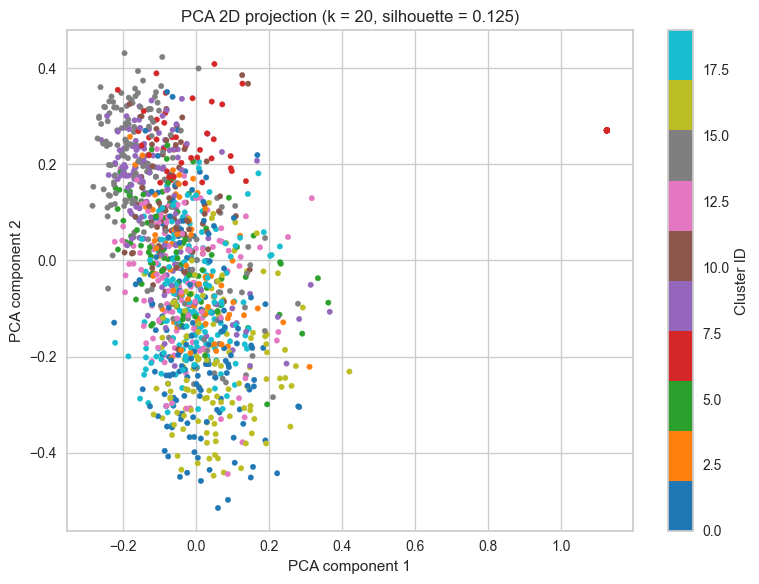

In [19]:

if __name__ == "__main__":
    run()